In [1]:
using Revise
using NeutrinoTelescopes
using Plots
using StaticArrays
using DataFrames
using StatsPlots
using LinearAlgebra

using Rotations
using Formatting
using Distributions
import Pipe: @pipe

function plot_hits(target, groups...; ylabel="")
    l = grid(4, 4)
    plots = []

    coords = rad2deg.(target.pmt_coordinates)

    for (i, (theta, phi)) in enumerate(eachcol(coords))
        p = plot(title=format("θ={:.2f}, ϕ={:.2f}", theta, phi), titlefontsize=8, )

        for grp in groups
            this_hits = get(grp, (pmt_id=i,), nothing)
       
            if !isnothing(this_hits)
                histogram!(p, this_hits[:, :time], bins=70:1:150, xlabel="Time (ns)", #yscale=:log10,
                #ylim=(0.1, 5000),
                label="",
                yscale=:log10, ylim=(0.5, 1000),
                alpha=0.9,
                ylabel=ylabel,
                margin=3.2Plots.mm, xlabelfontsize=8, ylabelfontsize=8
                )
            end
        end

        push!(plots, p)

    end
    return plot(plots..., layout=l, size=(1200, 800))
end

function plot_pmt_map(target, xmap ; ylabel="")
    l = grid(4, 4)
    plots = []

    coords = rad2deg.(target.pmt_coordinates)

    for (i, (theta, phi)) in enumerate(eachcol(coords))
        p = plot(title=format("θ={:.2f}, ϕ={:.2f}", theta, phi), titlefontsize=8, )

        x = get(xmap, i, nothing)

        if isnothing(x)
            continue
        end
        plot!(p, x, label="", ylabel=ylabel, xlabel="Time (ns)",
            margin=3.2Plots.mm, xlabelfontsize=8, ylabelfontsize=8)

        push!(plots, p)

    end
    return plot(plots..., layout=l, size=(1200, 800))
end


function map_f_over_pmts(target, f, input)
    out_d = []
    for pmt_id in 1:get_pmt_count(target)
        if typeof(input) <: GroupedDataFrame
            in = get(input, (pmt_id=pmt_id,), nothing)
        else
            in = get(input, pmt_id, nothing)
        end
        if !isnothing(in)
            out = f(in)
            push!(out_d, (pmt_id, out))
        else
            push!(out_d, (pmt_id, nothing))
        end
        
    end
    
    return Dict(out_d)
    
end




# Photon Propagation

## Medium Setup
The `MediumProperties` type (and subtypes) hold information about the properties of the medium.
Currently, only properties for Cascadia basin are implemented:
- Scattering length is based on concentration of small / large particls (copied from clsim)
- Absorption length is the STRAW attenuation length (conservative)
- Refractive index is from Quan & Fry (based on salinity, pressure and temperature from cascadia site)
- Density is from DPPIR105
- Radiation length is from PDG

In [2]:
medium = make_cascadia_medium_properties(0.99f0)
material_density(medium), radiation_length(medium)

(1013.2627f0, 36.08f0)

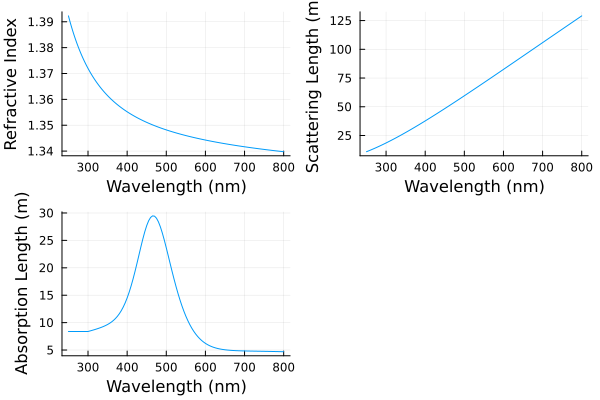

In [3]:
wavelengths = 250.:800 # nm

p1 = plot(wavelengths, refractive_index.(wavelengths, Ref(medium)), xlabel="Wavelength (nm)", ylabel="Refractive Index", label="")
p2 = plot(wavelengths, scattering_length.(wavelengths, Ref(medium)), xlabel="Wavelength (nm)", ylabel="Scattering Length (m)", label="")
p3 = plot(wavelengths, absorption_length.(wavelengths, Ref(medium)), xlabel="Wavelength (nm)", ylabel="Absorption Length (m)", label="")

plot(p1, p2, p3, layout= grid(2, 2))


## Setup Emitter & Target

Here, we define a `MultiPMTDetector` target that is offset from the emitter along the z-axis by `distance`.
The pmt coordinates are supplied by the `make_pom_pmt_coordinates` function. The emitter is defined in two stages:
We define a `Particle`, which is then converted into a `PhotonSource` (`PointlikeCherenkovEmitter` and `ExtendedCherenkovEmitter`).
We can also define more specialized light sources, such as an Axicone or a pencil beam.

In [50]:
distance = 20f0
pmt_area=Float32((75e-3 / 2)^2*π)
target_radius = 0.21f0
target = MultiPMTDetector(@SVector[0.0f0, 0.0f0, distance], target_radius, pmt_area, 
    make_pom_pmt_coordinates(Float32))


zenith_angle = 45f0
azimuth_angle = 0f0

particle = Particle(
        @SVector[0.0f0, 0f0, 0.0f0],
        sph_to_cart(deg2rad(zenith_angle), deg2rad(azimuth_angle)),
        0f0,
        Float32(1E5),
        PEMinus
)

cher_spectrum = CherenkovSpectrum((300f0, 800f0), 30, medium)
mono_spectrum = Monochromatic(405f0)

prop_source_pl = PointlikeCherenkovEmitter(particle, medium, (300f0, 800f0))
prop_source_ext = ExtendedCherenkovEmitter(particle, medium, (300f0, 800f0))
prop_source_axi = AxiconeEmitter(
    @SVector[0.0f0, 0f0, 0.0f0],
    @SVector[0.0f0, 0f0, 1.0f0],
    0f0,
    Int64(1E11),
    deg2rad(40f0))
prop_source_pencil_beam = PencilEmitter(
    @SVector[0.0f0, 0f0, 0.0f0],
    @SVector[0.0f0, 0f0, 1.0f0],
    0f0,
    Int64(1E11)
)
#prop_source_che = PointlikeCherenkovEmitter(particle, medium, (300f0, 800f0))


PencilEmitter{Float32}(Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 1.0], 0.0f0, 100000000000)

## Propagate Photons

In [51]:
photons = propagate_photons(prop_source_ext, target, medium, cher_spectrum)
photons[1, :]

DataFrameRow
 Row │ position                           direction                          w ⋯
     │ SArray…                            SArray…                            F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Float32[0.0216106, -0.0519737, 1…  Float32[-0.185684, -0.00307041, …    ⋯
                                                               3 columns omitted

## Make Hits From Photons
In order to convert the detected photons into hits, we have to define a module orientation (rotation matrix).
The identity matrix will leave the pmt coordinated unchanged. Hits are the resampled (using the photon weights)

In [52]:
orientation = RotMatrix3(I)
hits = make_hits_from_photons(photons, prop_source_ext, target, medium, orientation)
resampled_hits = resample_simulation(hits)
res_grp_pmt = groupby(resampled_hits, :pmt_id)

GroupedDataFrame with 13 groups based on key: pmt_id
First Group (1133 rows): pmt_id = 1
  Row │ pmt_id  time    
      │ Int64   Float32 
──────┼─────────────────
    1 │      1  92.568
    2 │      1  91.4982
    3 │      1  90.8894
    4 │      1  93.4626
    5 │      1  92.1838
    6 │      1  93.5458
    7 │      1  95.0028
    8 │      1  91.0767
  ⋮   │   ⋮        ⋮
 1126 │      1  92.0612
 1127 │      1  92.4448
 1128 │      1  91.225
 1129 │      1  95.9332
 1130 │      1  93.8607
 1131 │      1  91.5519
 1132 │      1  92.3473
 1133 │      1  91.9434
       1117 rows omitted
⋮
Last Group (363 rows): pmt_id = 16
 Row │ pmt_id  time     
     │ Int64   Float32  
─────┼──────────────────
   1 │     16   91.2806
   2 │     16   93.2949
   3 │     16   93.2735
   4 │     16  102.37
   5 │     16   95.7732
   6 │     16   91.204
   7 │     16   90.6476
   8 │     16   91.4261
  ⋮  │   ⋮        ⋮
 356 │     16   90.8814
 357 │     16   92.2862
 358 │     16   91.0279
 359 │     16   94.6778
 360 │     16   92.1317
 361 │     16   91.0105
 362 │     16   91.4078
 363 │     16   93.6058
        347 rows omitted

map_f_over_pmts (generic function with 2 methods)

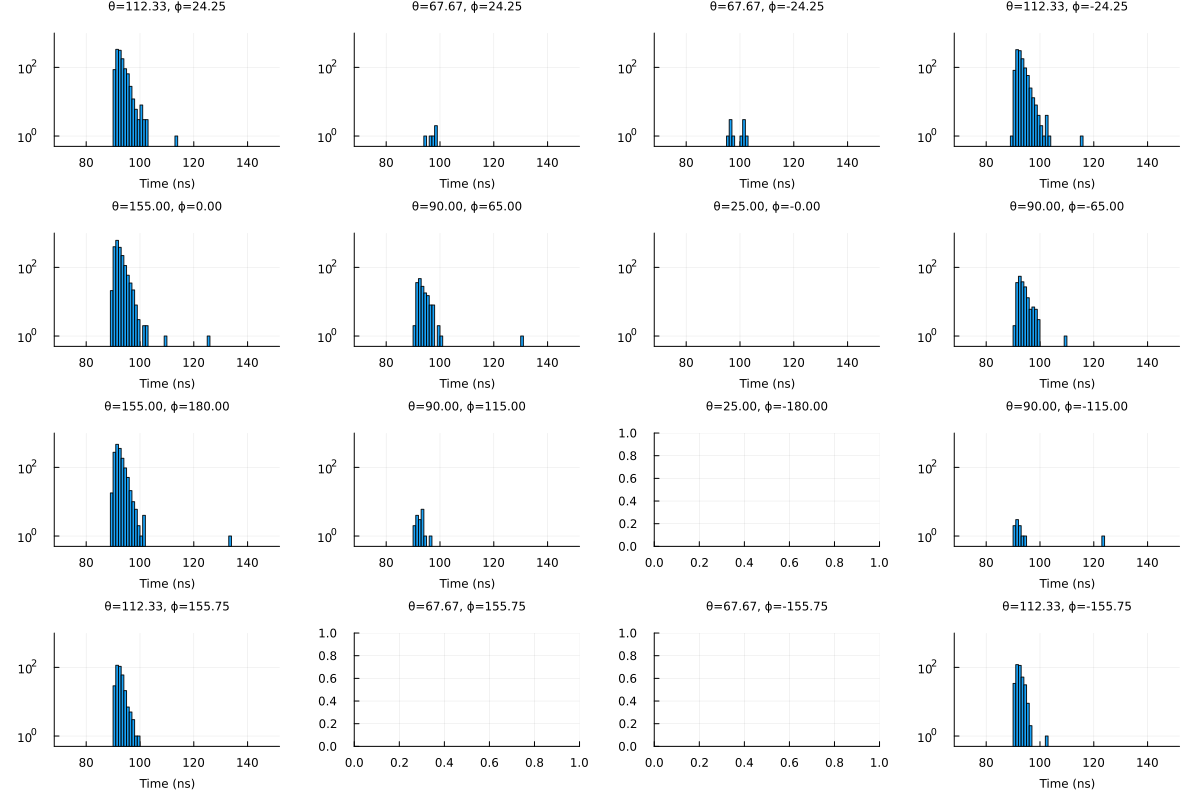

In [54]:
plot_hits(target, res_grp_pmt)

In [55]:
resampled_hits_pl = @pipe (
    propagate_photons(prop_source_pl, target, medium, cher_spectrum) |>
    make_hits_from_photons(_, prop_source_pl, target, medium, orientation) |>
    resample_simulation(_)
)

15577×2 DataFrame
   Row │ pmt_id  time    
       │ Int64   Float32 
───────┼─────────────────
     1 │      1  90.0857
     2 │      1  91.1677
     3 │      1  89.7817
     4 │      1  90.0583
     5 │      1  89.9997
     6 │      1  90.5714
     7 │      1  90.9937
     8 │      1  90.3997
   ⋮   │   ⋮        ⋮
 15571 │     16  89.9514
 15572 │     16  90.3881
 15573 │     16  90.5189
 15574 │     16  90.7837
 15575 │     16  90.6988
 15576 │     16  90.1297
 15577 │     16  90.3872
       15562 rows omitted

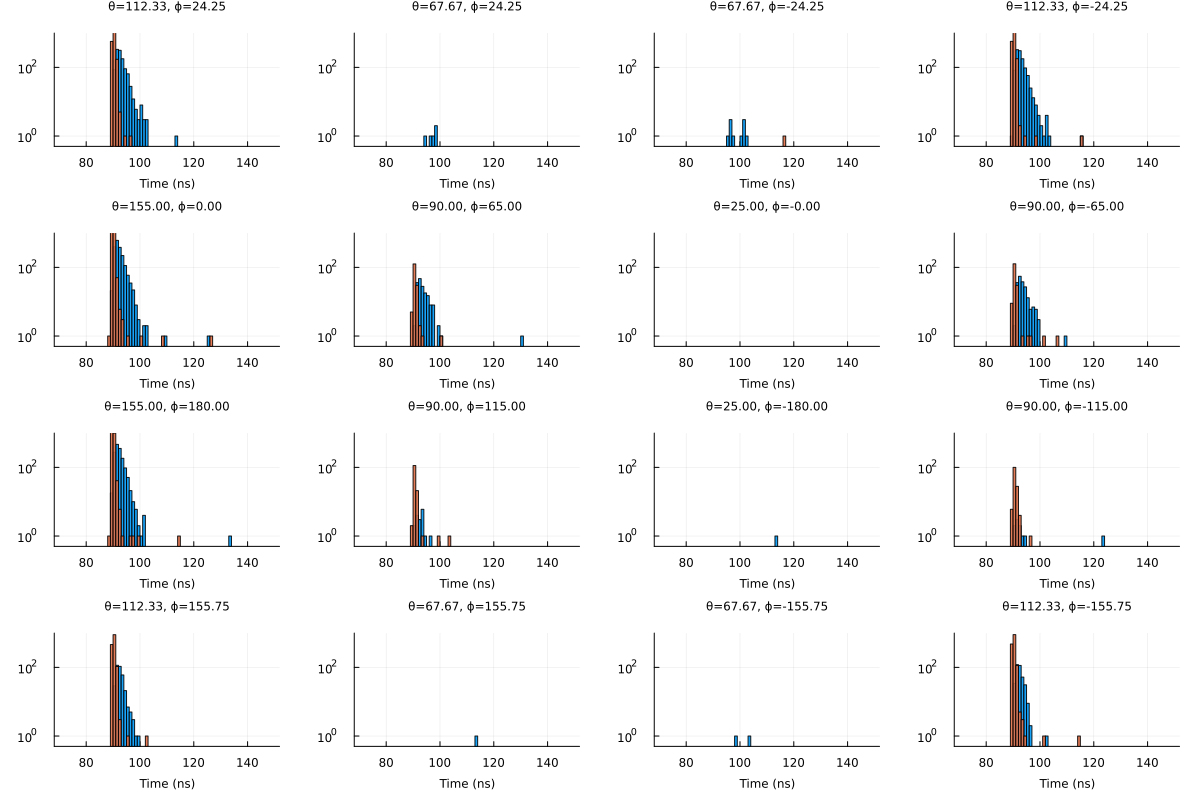

In [56]:
res_grp_pmt_pl = groupby(resampled_hits_pl, :pmt_id)
plot_hits(target, res_grp_pmt, res_grp_pmt_pl)

## Simulate Electronics

- Convert detected photons (photons that are converted at the photo cathode) into "charge" - ie. the ampltiude of the resulting PMT pulse.
- Apply the transit time (with TTS) to calculate the pulse time
- Create a PMT pulse by scaling the pulse template with the `charge` and shifting it to the pulse time.
- Sum all pulses to create the waveform
- Digitize the waveform by applying LP filter and discretization



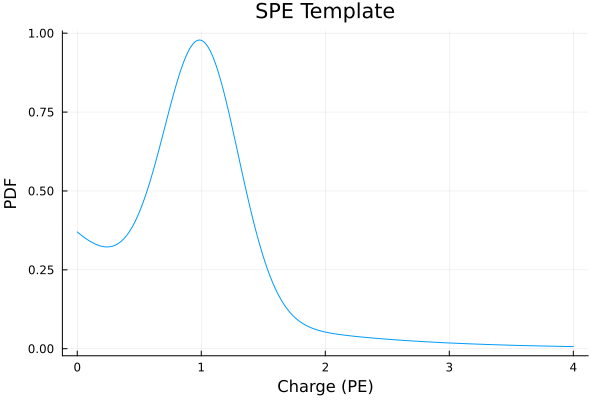

In [57]:
spe_d = make_spe_dist(STD_PMT_CONFIG.spe_template)
xs = 0:0.01:4
plot(xs, pdf.(spe_d, xs), xlabel="Charge (PE)", ylabel="PDF", label="", title="SPE Template")


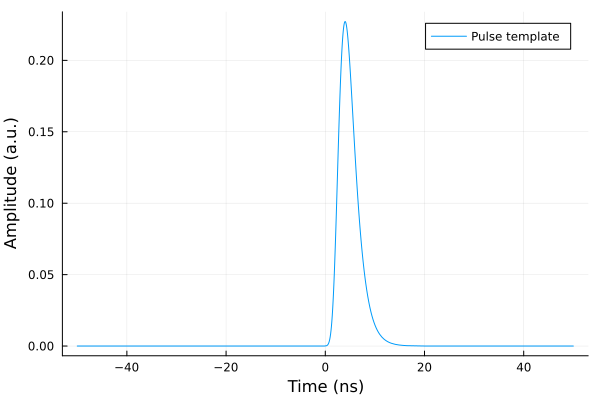

In [58]:
plot(x -> evaluate_pulse_template(STD_PMT_CONFIG.pulse_model, 0.0, x), -50, 50, ylabel="Amplitude (a.u.)", xlabel="Time (ns)", label="Pulse template")


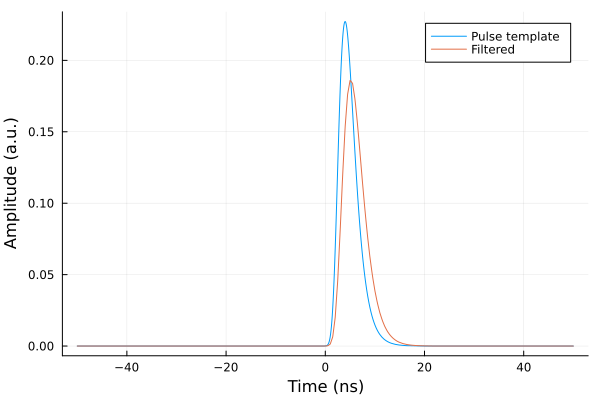

In [59]:
plot!(x -> evaluate_pulse_template(STD_PMT_CONFIG.pulse_model_filt, 0.0, x), -50, 50, label="Filtered")


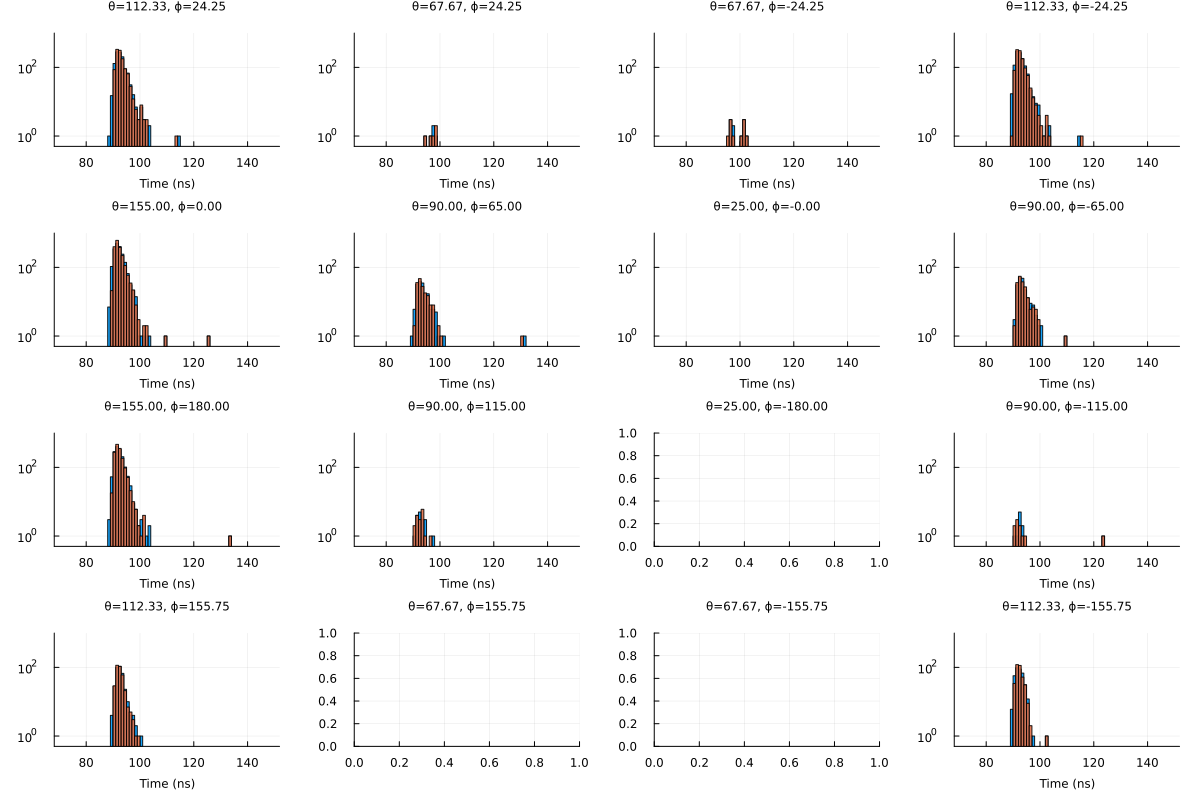

In [60]:
resampled_hits_tts = copy(resampled_hits; copycols=true)
resampled_hits_tts = subtract_mean_tt!(apply_tt!(resampled_hits_tts, STD_PMT_CONFIG.tt_dist), STD_PMT_CONFIG.tt_dist)
plot_hits(target, groupby(resampled_hits_tts, :pmt_id), res_grp_pmt)

In [61]:
pulse_map = map_f_over_pmts(
    target,
    hits -> PulseSeries(hits, STD_PMT_CONFIG.spe_template, STD_PMT_CONFIG.pulse_model),
    res_grp_pmt
)

wfs = map_f_over_pmts(
    target,
    pulses -> digitize_waveform(
            pulses,
            STD_PMT_CONFIG.sampling_freq,
            STD_PMT_CONFIG.adc_freq,
            STD_PMT_CONFIG.noise_amp,
            STD_PMT_CONFIG.lp_filter
        ),
    pulse_map)

reco_pulses = map_f_over_pmts(
    target,
    wf -> unfold_waveform(
        wf,
        STD_PMT_CONFIG.pulse_model_filt,
        STD_PMT_CONFIG.unf_pulse_res,
        0.2,
        :fnnls),
    wfs)

Dict{Int64, Union{Nothing, PulseSeries{Vector{Float64}, InterpolatedPulse}}} with 16 entries:
  5  => PulseSeries{Vector{Float64}, InterpolatedPulse}([41.692, 50.192, 58.192…
  16 => PulseSeries{Vector{Float64}, InterpolatedPulse}([42.1859, 50.6859, 58.6…
  12 => PulseSeries{Vector{Float64}, InterpolatedPulse}([88.4722, 92.4722, 92.9…
  8  => PulseSeries{Vector{Float64}, InterpolatedPulse}([51.3104, 59.3104, 67.3…
  1  => PulseSeries{Vector{Float64}, InterpolatedPulse}([42.2625, 50.7625, 58.7…
  6  => PulseSeries{Vector{Float64}, InterpolatedPulse}([67.2799, 75.2799, 85.2…
  11 => nothing
  9  => PulseSeries{Vector{Float64}, InterpolatedPulse}([42.1539, 50.1539, 58.1…
  14 => nothing
  3  => PulseSeries{Vector{Float64}, InterpolatedPulse}([95.0027, 95.5027, 101.…
  7  => PulseSeries{Vector{Float64}, InterpolatedPulse}([190.136, 191.636], [0.…
  4  => PulseSeries{Vector{Float64}, InterpolatedPulse}([41.9242, 50.4242, 58.4…
  13 => PulseSeries{Vector{Float64}, InterpolatedPulse}([42.6988

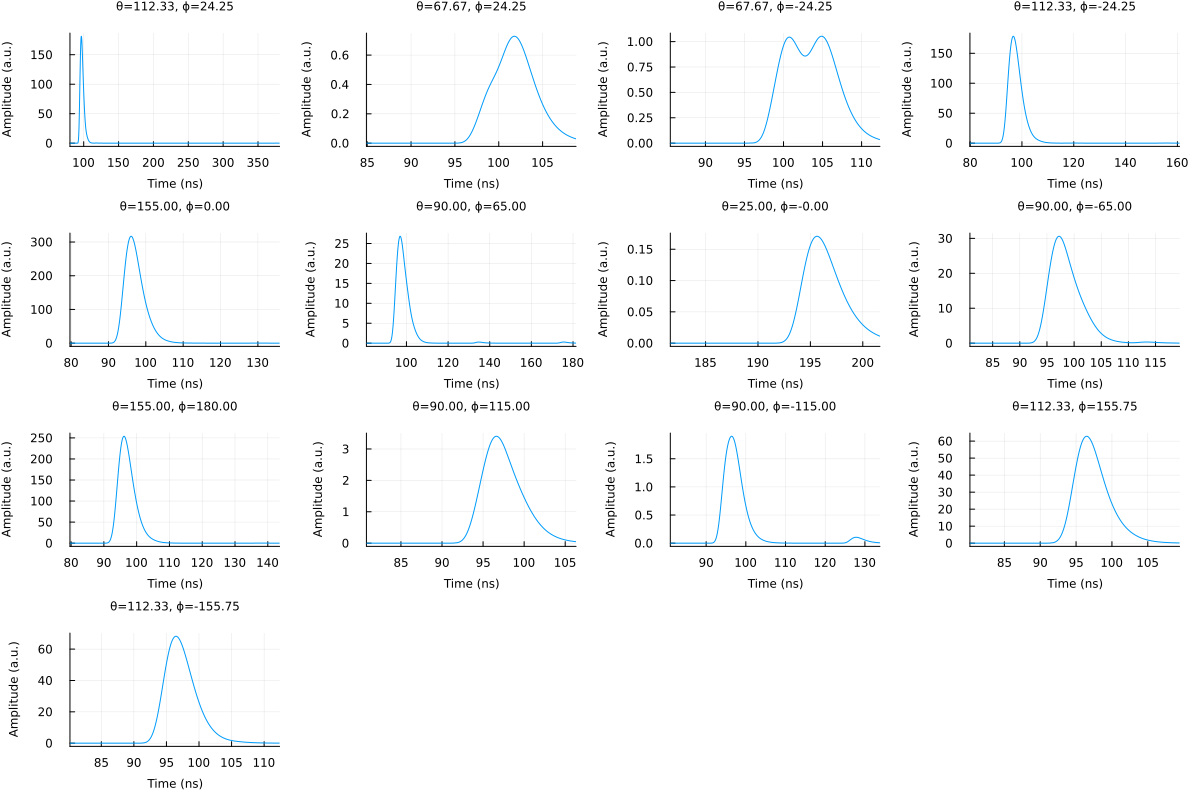

In [62]:
plot_pmt_map(target, pulse_map; ylabel="Amplitude (a.u.)")

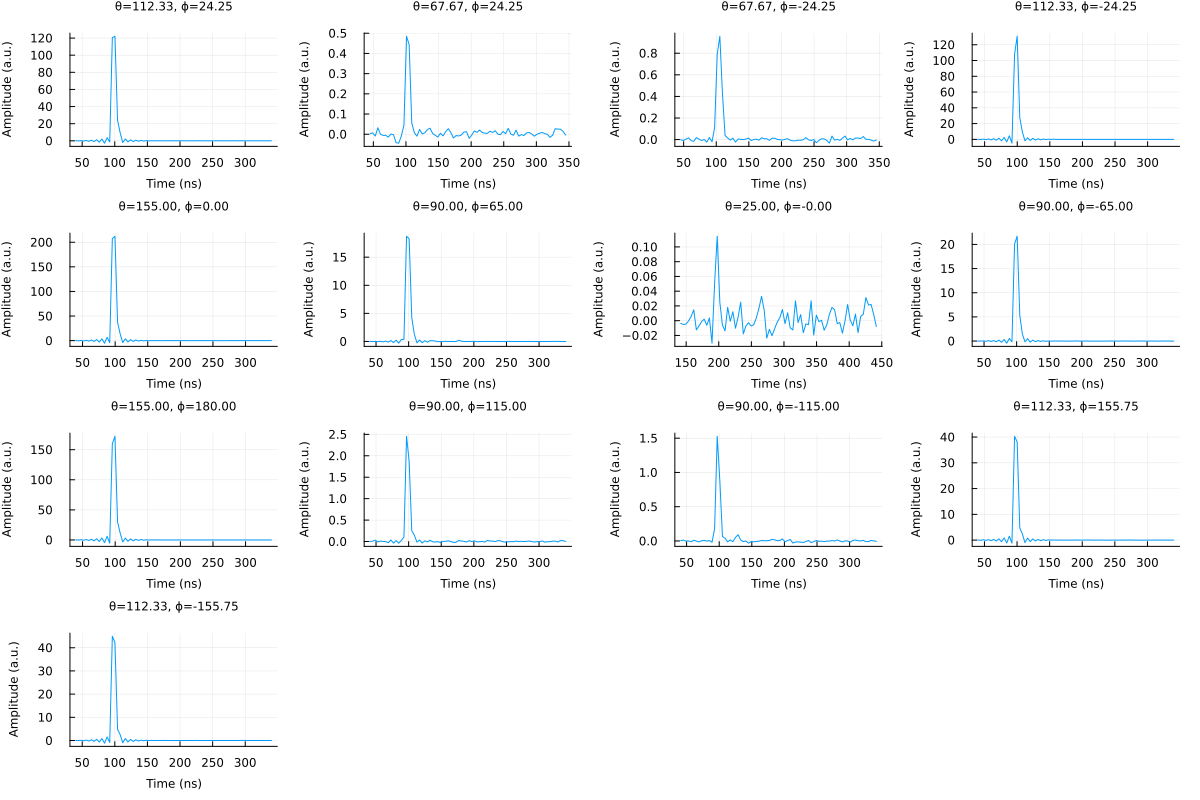

In [63]:
plot_pmt_map(target, wfs; ylabel="Amplitude (a.u.)")

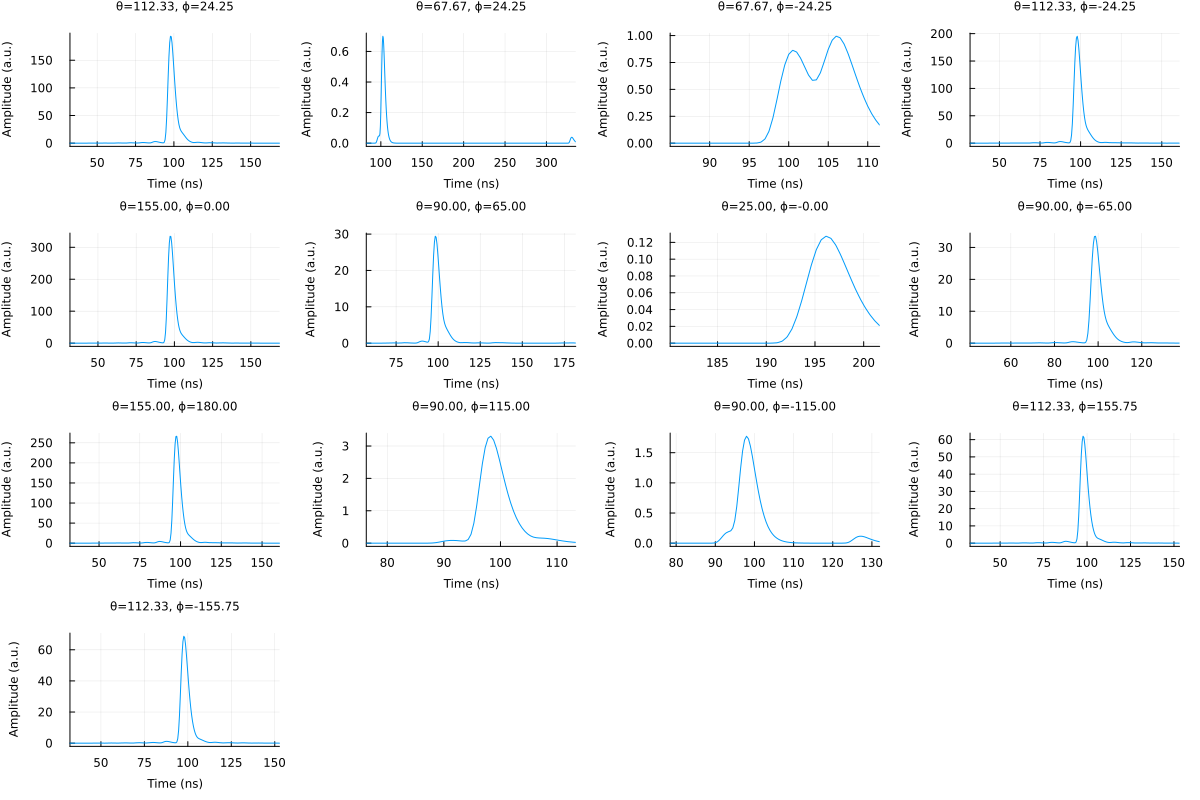

In [64]:
plot_pmt_map(target, reco_pulses; ylabel="Amplitude (a.u.)")

In [67]:
medium2 = make_cascadia_medium_properties(0.9f0)
photons2 = propagate_photons(prop_source_ext, target, medium2, cher_spectrum)



1365327×5 DataFrame
     Row │ position                           direction                        ⋯
         │ SArray…                            SArray…                          ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ Float32[0.0216106, -0.0519737, 1…  Float32[-0.185684, -0.00307041,  ⋯
       2 │ Float32[0.0978675, 0.174877, 19.…  Float32[-0.272204, 0.0108807, 0.
       3 │ Float32[0.102153, -0.168617, 19.…  Float32[-0.265049, -0.00697472,
       4 │ Float32[-0.0124682, -0.0141533, …  Float32[-0.120357, -0.000795512,
       5 │ Float32[0.0408316, -0.0146415, 1…  Float32[-0.22825, -0.000890814,  ⋯
       6 │ Float32[0.148306, 0.0956217, 19.…  Float32[-0.240357, 0.00586693, 0
       7 │ Float32[0.208845, 0.0113685, 20.…  Float32[0.109843, 0.349707, 0.93
       8 │ Float32[0.0606841, 0.108596, 19.…  Float32[0.0295142, -0.130386, 0.
    ⋮    │                 ⋮                                  ⋮                ⋱
 1365321 │ Float32[0.149401, 0.0890445, 19.…  Float32[-0.0188453, -0.0780368,  ⋯
 1365322 │ Float32[0.10611, -0.164167, 19.9…  Float32[-0.114522, -0.00917802,
 1365323 │ Float32[0.101465, -0.0808636, 19…  Float32[-0.231174, -0.00493402,
 1365324 │ Float32[0.0312467, -0.194743, 19…  Float32[-0.185641, -0.0751365, 0
 1365325 │ Float32[0.0797753, 0.0532051, 19…  Float32[-0.136201, 0.0030383, 0. ⋯
 1365326 │ Float32[0.0354423, -0.161386, 19…  Float32[-0.233854, -0.0098131, 0
 1365327 │ Float32[-0.117025, 0.121884, 19.…  Float32[-0.109137, 0.00672531, 0
                                              4 columns and 1365312 rows omitted

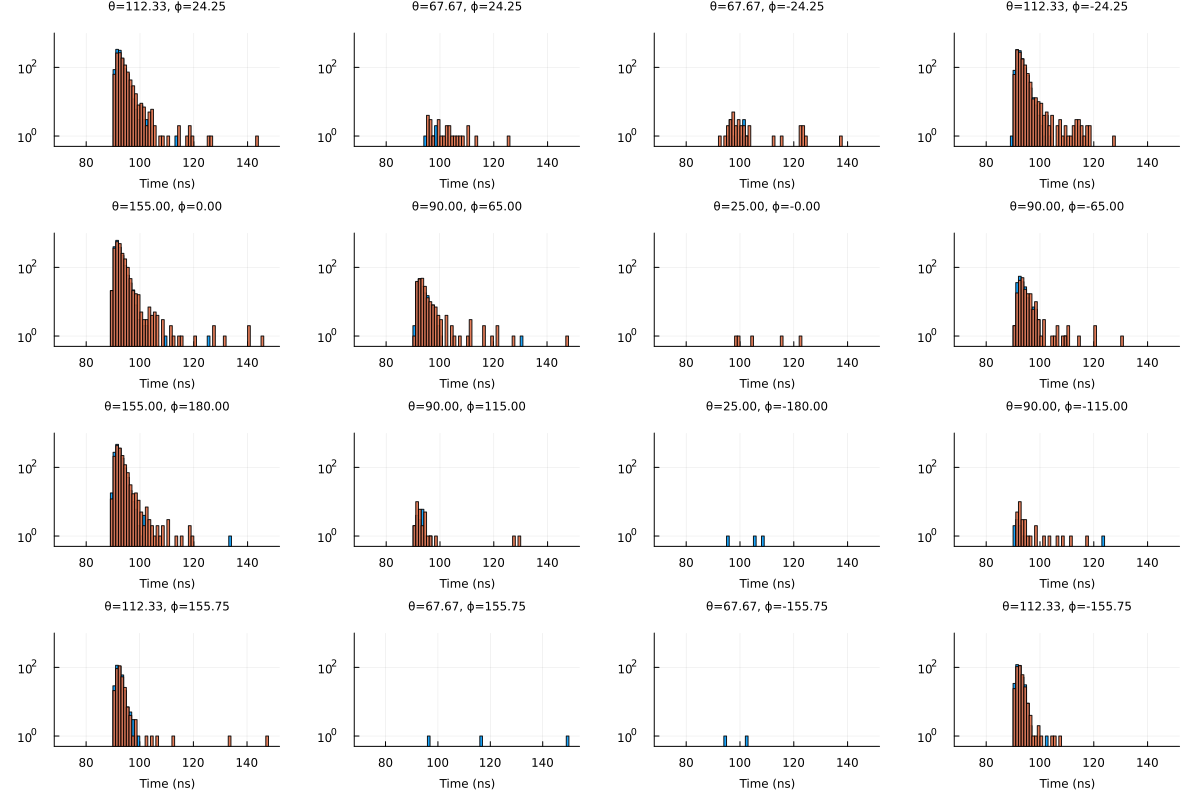

In [68]:
hits2 = make_hits_from_photons(photons2, prop_source_ext, target, medium, orientation)
resampled_hits2 = resample_simulation(hits2)
res_grp_pmt2 = groupby(resampled_hits2, :pmt_id)

plot_hits(target, res_grp_pmt, res_grp_pmt2)